In [119]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from tensorflow.keras.datasets import reuters

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# 프로젝트 목표
1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?	
- 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.
2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?	
- Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.
3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?	
- 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.

## 실험 내용

### 독립 변수
num_words = 1000, 3000, 5000, 8000, 10000, 15000, 20000, None(30980)

In [55]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

# 📌 데이터를 하나의 리스트로 합치기
all_samples = list(x_train) + list(x_test)  # 리스트로 변환 후 합치기

# 📌 단어별 등장 횟수 계산
word_counts = Counter(word for sample in all_samples for word in sample)

# 📌 전체 단어 수 출력
print("전체 단어 수 (num_words 크기):", len(word_counts))

전체 단어 수 (num_words 크기): 30980


In [57]:
len(all_samples)

11228

In [59]:
len(list(x_train))

8982

### 종속변수
F1-score, Accuracy

### 사용 모델
Naïve Bayes Classification
Complement Naive Bayes (CNB)
Logistic Regression (LR)
Support Vector Classifier (SVC)
Decision Tree (DT)
Random Forest (RF)
Gradient Boosting Tree (GBT)
Voting(soft)
conv1D
RNN

## 코드 구현

### 데이터 정제

In [29]:
RANDOM_STATE = 42

In [30]:
def data_preprocessing(num_words = 10000):
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    word_index = reuters.get_word_index(path="reuters_word_index.json")
    index_to_word = { index+3 : word for word, index in word_index.items() }
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_to_word[index]=token
    decoded = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        decoded.append(t)

    x_train = decoded
    
    decoded = []
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        decoded.append(t)

    x_test = decoded
    
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train)
    print("x_train_dtm : ",x_train_dtm.shape)
    
    tfidf_transformer = TfidfTransformer()
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
    print("tfidfv : ",tfidfv.shape)
    
    x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
    print("x_test_dtm : ",x_test_dtm.shape)
    tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
    print("tfidfv_test : ",tfidfv_test.shape)
    
    return tfidfv, y_train, tfidfv_test, y_test
    
    

#### num_words = 1000

In [49]:
tfidfv, y_train, tfidfv_test, y_test = data_preprocessing(1000)

x_train_dtm :  (8982, 969)
tfidfv :  (8982, 969)
x_test_dtm :  (2246, 969)
tfidfv_test :  (2246, 969)


In [35]:
def machine_model_test(models, tfidfv, y_train, tfidfv_test, y_test):
    results = []
    
    for name, model in models.items():
        
        model.fit(tfidfv, y_train)
        predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
        acc = accuracy_score(y_test, predicted)
        f1 = f1_score(y_test, predicted, average="weighted")
        print(f"{name}정확도:", acc)
        print(f"{name}F1-socre:", f1)
    
        results.append([name, acc, f1])
    
    df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "F1-score"])
    return df_results
    

In [36]:
'''
Naïve Bayes Classification, Complement Naive Bayes (CNB) 
Logistic Regression (LR,) Support Vector Classifier (SVC) 
Decision Tree (DT), Random Forest (RF) 
Gradient Boosting Tree (GBT), Voting(soft)
'''

models = {
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "Logistic Regression": LogisticRegression(C=10000, penalty='l2', max_iter=3000),
    "SVM": LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=5, random_state=RANDOM_STATE),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE) 
}


In [39]:
result_df_1000 = machine_model_test(models, tfidfv, y_train, tfidfv_test, y_test)

MultinomialNB정확도: 0.6856634016028496
MultinomialNBF1-socre: 0.6365038314524903
ComplementNB정확도: 0.7346393588601959
ComplementNBF1-socre: 0.6972989886481723
Logistic Regression정확도: 0.738646482635797
Logistic RegressionF1-socre: 0.7325581163498371


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM정확도: 0.7252894033837934
SVMF1-socre: 0.7214776039901196
Decision Tree정확도: 0.6170970614425646
Decision TreeF1-socre: 0.5451941414688276
Random Forest정확도: 0.7083704363312555
Random ForestF1-socre: 0.6856216638357706
Gradient Boosting정확도: 0.7390917186108638
Gradient BoostingF1-socre: 0.7307163519884774


In [50]:
voting_clf = VotingClassifier(estimators=[
            ("lr", models["Logistic Regression"]),
            ("cnb", models["ComplementNB"]),
            ("gb", models["Gradient Boosting"])
        ], voting="soft")

voting_clf.fit(tfidfv, y_train)

predicted = voting_clf.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc = accuracy_score(y_test, predicted)
f1 = f1_score(y_test, predicted, average="weighted")

voting_df = pd.DataFrame([["Voting", acc, f1]], 
                         columns=["Model", "Accuracy", "F1-score"])

result_df_1000 = pd.concat([result_df_1000, voting_df], ignore_index=True)


In [51]:
result_df_1000

,Model,Accuracy,F1-score
0,MultinomialNB,0.685663,0.636504
1,ComplementNB,0.734639,0.697299
2,Logistic Regression,0.738646,0.732558
3,SVM,0.725289,0.721478
4,Decision Tree,0.617097,0.545194
5,Random Forest,0.708370,0.685622
6,Gradient Boosting,0.739092,0.730716
7,Voting,0.760908,0.753970


#### num_words=3000

In [41]:
tfidfv, y_train, tfidfv_test, y_test = data_preprocessing(3000)

x_train_dtm :  (8982, 2919)
tfidfv :  (8982, 2919)
x_test_dtm :  (2246, 2919)
tfidfv_test :  (2246, 2919)


In [42]:
result_df_3000 = machine_model_test(models, tfidfv, y_train, tfidfv_test, y_test)

MultinomialNB정확도: 0.6874443455031166
MultinomialNBF1-socre: 0.6266168450864102
ComplementNB정확도: 0.7644701691896705
ComplementNBF1-socre: 0.7369718160654114
Logistic Regression정확도: 0.7880676758682101
Logistic RegressionF1-socre: 0.7837257156308677


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM정확도: 0.7586821015138023
SVMF1-socre: 0.7570491245148095
Decision Tree정확도: 0.6255565449688335
Decision TreeF1-socre: 0.5803555721197996
Random Forest정확도: 0.695013357079252
Random ForestF1-socre: 0.6702241091709462
Gradient Boosting정확도: 0.7693677649154052
Gradient BoostingF1-socre: 0.7658388970410627


In [47]:
voting_clf = VotingClassifier(estimators=[
            ("lr", models["Logistic Regression"]),
            ("cnb", models["ComplementNB"]),
            ("gb", models["Gradient Boosting"])
        ], voting="soft")

voting_clf.fit(tfidfv, y_train)

predicted = voting_clf.predict(tfidfv_test) #테스트 데이터에 대한 예측
acc = accuracy_score(y_test, predicted)
f1 = f1_score(y_test, predicted, average="weighted")

voting_df = pd.DataFrame([["Voting", acc, f1]], 
                         columns=["Model", "Accuracy", "F1-score"])

result_df_3000 = pd.concat([result_df_3000, voting_df], ignore_index=True)

In [48]:
result_df_3000

,Model,Accuracy,F1-score
0,MultinomialNB,0.687444,0.626617
1,ComplementNB,0.764470,0.736972
2,Logistic Regression,0.788068,0.783726
3,SVM,0.758682,0.757049
4,Decision Tree,0.625557,0.580356
5,Random Forest,0.695013,0.670224
6,Gradient Boosting,0.769368,0.765839
7,Voting,0.800980,0.796789


### 딥러닝

#### num_words=1000

In [86]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

In [125]:
# 일반 판다스 데이터프레임을 텐서플로우 데이터셋으로 변환
def tensorflow_dataset(input_x, input_y, buffer_size, batch_size):
    tf_data = tf.data.Dataset.from_tensor_slices((input_x, input_y))
    tf_data = tf_data.shuffle(buffer_size)
    tf_data = tf_data.repeat()
    tf_data = tf_data.batch(batch_size)
    tf_data = tf_data.prefetch(buffer_size = -1)
    return tf_data 

In [88]:
max_len = np.max(list(map(lambda x: len(x), x_train)))
print(f"문장의 최대 길이 : {max_len}")

batch_size = 32
embedd_size = 100

# 훈련셋
pad_x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen = max_len)
num_words = np.max(pad_x_train) + 1
y_tmp = y_train.reshape(-1,1)
buffer = len(y_tmp)
tf_data = tensorflow_dataset(pad_x_train, y_tmp, buffer, batch_size)

문장의 최대 길이 : 2376


In [89]:
# 테스트셋
total_num_test = len(x_test)
pad_x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen = max_len)
y_tmp_test = y_test.reshape(-1,1)
tf_test = tensorflow_dataset(pad_x_test, y_tmp_test, buffer, batch_size)

In [126]:
class Conv1D(tf.keras.Model):
    
    def __init__(self, vocab_size, embedd_size):
        super(Conv1D, self).__init__()
        self.embedd = tf.keras.layers.Embedding(input_dim = vocab_size,
                                                output_dim = embedd_size)
        self.cnn = tf.keras.layers.Conv1D(64, kernel_size = 3)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(64, activation = "relu")
        self.outputs = tf.keras.layers.Dense(num_classes, activation = "softmax")
        
    def call(self, x):
        x = self.embedd(x)
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.outputs(x)
        return x

In [91]:
model = Conv1D(num_words, embedd_size)
model.compile(loss = "sparse_categorical_crossentropy",
                  optimizer = "adam",
                  metrics = ["accuracy"])
model.fit(tf_data,
              steps_per_epoch = buffer // batch_size,
              epochs = 5)

test_loss, test_acc = model.evaluate(tf_test, steps = total_num_test // batch_size)
print(f"test loss : {test_loss}")
print(f"test acc : {test_acc}")

Epoch 1/5
280/280 [==============================] - 3s 9ms/step - loss: 1.8757 - accuracy: 0.5513
Epoch 2/5
280/280 [==============================] - 3s 9ms/step - loss: 1.1360 - accuracy: 0.7271
Epoch 3/5
280/280 [==============================] - 3s 9ms/step - loss: 0.6932 - accuracy: 0.8327
Epoch 4/5
280/280 [==============================] - 3s 9ms/step - loss: 0.4452 - accuracy: 0.9002
Epoch 5/5
70/70 [==============================] - 0s 3ms/step - loss: 1.5877 - accuracy: 0.7054
test loss : 1.5877238512039185
test acc : 0.7053571343421936


In [92]:
y_pred = model.predict(pad_x_test) #테스트 데이터에 대한 예측
y_pred = np.argmax(y_pred, axis = 1)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"정확도:", acc)
print(f"F1-socre:", f1)

정확도: 0.705253784505788
F1-socre: 0.6833005393312009


#### num_words = 3000

In [77]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=3000, test_split=0.2)

In [78]:
max_len = np.max(list(map(lambda x: len(x), x_train)))
print(f"문장의 최대 길이 : {max_len}")


batch_size = 32
embedd_size = 100

# 훈련셋
pad_x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen = max_len)
num_words = np.max(pad_x_train) + 1
y_tmp = y_train.reshape(-1,1)
buffer = len(y_tmp)
tf_data = tensorflow_dataset(pad_x_train, y_tmp, buffer, batch_size)

문장의 최대 길이 : 2376


In [79]:
# 테스트셋
total_num_test = len(x_test)
pad_x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen = max_len)
y_tmp_test = y_test.reshape(-1,1)
tf_test = tensorflow_dataset(pad_x_test, y_tmp_test, buffer, batch_size)

In [80]:
model = Conv1D(num_words, embedd_size)
model.compile(loss = "sparse_categorical_crossentropy",
                  optimizer = "adam",
                  metrics = ["accuracy"])
model.fit(tf_data,
              steps_per_epoch = buffer // batch_size,
              epochs = 5)

test_loss, test_acc = model.evaluate(tf_test, steps = total_num_test // batch_size)
print(f"test loss : {test_loss}")
print(f"test acc : {test_acc}")

Epoch 1/5
280/280 [==============================] - 3s 9ms/step - loss: 1.8785 - accuracy: 0.5318
Epoch 2/5
280/280 [==============================] - 3s 9ms/step - loss: 1.1046 - accuracy: 0.7355
Epoch 3/5
280/280 [==============================] - 3s 9ms/step - loss: 0.7103 - accuracy: 0.8258
Epoch 4/5
280/280 [==============================] - 3s 9ms/step - loss: 0.4470 - accuracy: 0.8989
Epoch 5/5
70/70 [==============================] - 0s 3ms/step - loss: 1.4596 - accuracy: 0.7036
test loss : 1.459555745124817
test acc : 0.7035714387893677


In [85]:
y_pred = model.predict(pad_x_test) #테스트 데이터에 대한 예측
y_pred = np.argmax(y_pred, axis = 1)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"정확도:", acc)
print(f"F1-socre:", f1)

정확도: 0.7039180765805877
F1-socre: 0.6843430448051621


#### num_words = 5000

In [132]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

max_len = np.max(list(map(lambda x: len(x), x_train)))
print(f"문장의 최대 길이 : {max_len}")


batch_size = 32
embedd_size = 100

# 훈련셋
pad_x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen = max_len)
num_words = np.max(pad_x_train) + 1
y_tmp = y_train.reshape(-1,1)
buffer = len(y_tmp)
tf_data = tensorflow_dataset(pad_x_train, y_tmp, buffer, batch_size)

# 테스트셋
total_num_test = len(x_test)
pad_x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen = max_len)
y_tmp_test = y_test.reshape(-1,1)
tf_test = tensorflow_dataset(pad_x_test, y_tmp_test, buffer, batch_size)

model = Conv1D(num_words, embedd_size)
model.compile(loss = "sparse_categorical_crossentropy",
                  optimizer = "adam",
                  metrics = ["accuracy"])
model.fit(tf_data,
              steps_per_epoch = buffer // batch_size,
              epochs = 5)

test_loss, test_acc = model.evaluate(tf_test, steps = total_num_test // batch_size)
print(f"test loss : {test_loss}")
print(f"test acc : {test_acc}")

y_pred = model.predict(pad_x_test) #테스트 데이터에 대한 예측
y_pred = np.argmax(y_pred, axis = 1)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"정확도:", acc)
print(f"F1-socre:", f1)

문장의 최대 길이 : 2376
Epoch 1/5
280/280 [==============================] - 3s 10ms/step - loss: 1.8219 - accuracy: 0.5665
Epoch 2/5
280/280 [==============================] - 3s 9ms/step - loss: 1.0317 - accuracy: 0.7526
Epoch 3/5
280/280 [==============================] - 3s 9ms/step - loss: 0.5779 - accuracy: 0.8675
Epoch 4/5
280/280 [==============================] - 3s 9ms/step - loss: 0.3547 - accuracy: 0.9249
Epoch 5/5
70/70 [==============================] - 0s 3ms/step - loss: 1.4520 - accuracy: 0.7183
test loss : 1.4519989490509033
test acc : 0.7183035612106323
정확도: 0.7186108637577916
F1-socre: 0.7000927041030134


#### num_words=8000

In [133]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=8000, test_split=0.2)

max_len = np.max(list(map(lambda x: len(x), x_train)))
print(f"문장의 최대 길이 : {max_len}")


batch_size = 32
embedd_size = 100

# 훈련셋
pad_x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen = max_len)
num_words = np.max(pad_x_train) + 1
y_tmp = y_train.reshape(-1,1)
buffer = len(y_tmp)
tf_data = tensorflow_dataset(pad_x_train, y_tmp, buffer, batch_size)

# 테스트셋
total_num_test = len(x_test)
pad_x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen = max_len)
y_tmp_test = y_test.reshape(-1,1)
tf_test = tensorflow_dataset(pad_x_test, y_tmp_test, buffer, batch_size)

model = Conv1D(num_words, embedd_size)
model.compile(loss = "sparse_categorical_crossentropy",
                  optimizer = "adam",
                  metrics = ["accuracy"])
model.fit(tf_data,
              steps_per_epoch = buffer // batch_size,
              epochs = 5)

test_loss, test_acc = model.evaluate(tf_test, steps = total_num_test // batch_size)
print(f"test loss : {test_loss}")
print(f"test acc : {test_acc}")

y_pred = model.predict(pad_x_test) #테스트 데이터에 대한 예측
y_pred = np.argmax(y_pred, axis = 1)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"정확도:", acc)
print(f"F1-socre:", f1)

문장의 최대 길이 : 2376
Epoch 1/5
280/280 [==============================] - 3s 9ms/step - loss: 1.8808 - accuracy: 0.5499
Epoch 2/5
280/280 [==============================] - 3s 9ms/step - loss: 1.0306 - accuracy: 0.7498
Epoch 3/5
280/280 [==============================] - 3s 9ms/step - loss: 0.5661 - accuracy: 0.8617
Epoch 4/5
280/280 [==============================] - 3s 9ms/step - loss: 0.3318 - accuracy: 0.9268
Epoch 5/5
70/70 [==============================] - 0s 3ms/step - loss: 1.3528 - accuracy: 0.7384
test loss : 1.3528350591659546
test acc : 0.7383928298950195
정확도: 0.738646482635797
F1-socre: 0.7210485713857214


## 회고

### num_words별 미등록 단어 확인

In [93]:
def count_unk_words(num_words=10000):
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    word_index = reuters.get_word_index(path="reuters_word_index.json")

    # 인덱스를 단어로 변환하는 딕셔너리 생성
    index_to_word = {index + 3: word for word, index in word_index.items()}
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_to_word[index] = token

    # 📌 UNK(미등록 단어) 개수 확인
    unk_count_train = sum(1 for sentence in x_train for word in sentence if word == 2)  # <unk> 인덱스는 2
    unk_count_test = sum(1 for sentence in x_test for word in sentence if word == 2)

    return unk_count_train, unk_count_test

In [94]:
num_words_list = [1000, 3000, 5000, 8000, 10000, 15000, 20000, None]
unk_results = []

In [95]:
for num_words in num_words_list:
    unk_train, unk_test = count_unk_words(num_words)
    unk_results.append([num_words, unk_train, unk_test])

In [97]:
df_unk = pd.DataFrame(unk_results, columns=["num_words", "UNK (train)", "UNK (test)"])
df_unk

,num_words,UNK (train),UNK (test)
0,1000.0,284013,72116
1,3000.0,136346,34589
2,5000.0,86091,21958
3,8000.0,48792,12633
4,10000.0,35703,9177
5,15000.0,18196,4725
6,20000.0,9222,2436
7,NaN,1,0


In [100]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
# UNK(2)를 포함한 문서 찾기
unk_train_sentences = [sample for sample in x_train if 2 in sample]

# 몇 개의 문서가 UNK(2)를 포함하는지 출력
print("UNK(2)를 포함한 train 문서 개수:", len(unk_train_sentences))

# 첫 번째 문서 출력
if len(unk_train_sentences) > 0:
    print("UNK(2)를 포함한 첫 번째 문서:", unk_train_sentences[0])


UNK(2)를 포함한 train 문서 개수: 1
UNK(2)를 포함한 첫 번째 문서: [1, 2849, 2968, 18895, 1457, 24, 782, 41, 525, 410, 4, 2988, 5, 3947, 10351, 6, 4, 403, 107, 144, 34, 194, 5326, 6, 25, 871, 58, 1195, 4638, 66, 3017, 1948, 8, 26695, 8102, 29801, 15911, 118, 10, 497, 522, 782, 34, 1810, 6, 1070, 827, 7, 4, 403, 51, 36, 152, 107, 144, 23, 194, 5326, 7, 4, 1937, 5, 380, 1094, 9, 380, 203, 9, 162, 52, 4436, 41, 45, 30, 1209, 500, 13, 194, 556, 4, 1948, 6682, 27, 4, 496, 2422, 1098, 824, 15911, 43, 669, 2849, 2968, 189, 64, 4, 307, 2053, 4754, 764, 348, 295, 715, 6237, 6, 1195, 2322, 9, 10, 715, 5, 1195, 6, 1195, 2322, 36, 8, 16, 64, 75, 2280, 220, 6, 1194, 4, 1385, 1507, 22, 4, 307, 2, 475, 7, 4, 6942, 403, 6, 4, 307, 23067, 359, 5, 4, 1195, 5, 5382, 3051, 6, 37, 38, 2330, 1894, 7, 9, 757, 4, 403, 15911, 8, 77, 64, 345, 550, 45, 85, 5492, 112, 2849, 881, 125, 1894, 57, 85, 21, 4, 503, 5, 141, 2135, 9, 7, 4, 500, 10199, 4, 1948, 824, 1826, 43, 669, 290, 107, 194, 1937, 58, 435, 23, 2250, 242, 112, 4, 881, 5,

In [101]:
# 인덱스를 단어로 변환
word_index = reuters.get_word_index()
index_to_word = {index + 3: word for word, index in word_index.items()}
index_to_word[0] = "<pad>"
index_to_word[1] = "<sos>"
index_to_word[2] = "<unk>"

# UNK(2)가 포함된 문서 복원
if len(unk_train_sentences) > 0:
    decoded_sentence = " ".join([index_to_word.get(index, "<unk>") for index in unk_train_sentences[0]])
    print("UNK(2)가 포함된 첫 번째 문서 복원:", decoded_sentence)


UNK(2)가 포함된 첫 번째 문서 복원: <sos> iran's navy commander warned that iran would close off the strait of hormuz entrance to the gulf if there was any disruption to its shipping or sea bound trade tehran radio said commodore mohammed hoseyn malekzadegan told a news conference iran was ready to maintain security in the gulf but he added if there is any disruption in the movement of our ships and our imports and exports this waterway would not be left open for any country the radio monitored by the british broadcasting corporation quoted malekzadegan as saying iran's navy now had the most advanced defensive equipment including long range shore to sea missiles and a range of sea to sea missiles he said it had also expanded operations to cover the whole region from the most <unk> point in the persian gulf to the most southerly part of the sea of oman referring to u s fleet movements in and near the gulf malekzadegan said they had so far not been directed against iran's interests their movements h

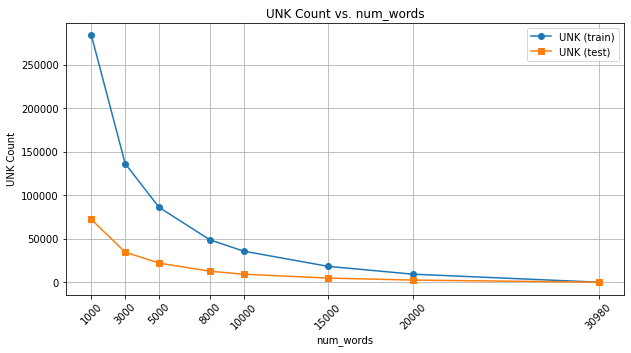

In [103]:
# None = 30980
df_unk = df_unk.fillna(30980)

plt.figure(figsize=(10, 5))
plt.plot(df_unk["num_words"], df_unk["UNK (train)"], marker='o', linestyle='-', label="UNK (train)")
plt.plot(df_unk["num_words"], df_unk["UNK (test)"], marker='s', linestyle='-', label="UNK (test)")

plt.xlabel("num_words")
plt.ylabel("UNK Count")
plt.title("UNK Count vs. num_words")
plt.xticks(df_unk["num_words"], rotation=45)  # X축 눈금 설정
plt.legend()
plt.grid(True)
plt.show()

- num_words = None 으로 모든 단어를 불러왔을때 train 데이터셋에서 1개의 UNK 값 발견
- UNK의 인덱스인 2 값이 raw data에 매핑되어있는 상태인걸 확인
- num_words 별 UNK 분포 살펴보니 10000~15000개가 적정 Num Words 값으로 생각됨

### 모델 결과 확인

In [114]:
data = {
    "Model": [
        "NBC", "CNB", "LR", 
        "SVC", "DT", "RF", 
        "GBT", "Voting(soft)"
    ],
    "1000": [0.6365, 0.6972, 0.7325, 0.7214, 0.5451, 0.6856, 0.7307, 0.7539],
    "3000": [0.6266, 0.7369, 0.7837, 0.7570, 0.5803, 0.6702, 0.7658, 0.7967],
    "5000": [0.6013, 0.7459, 0.7986, 0.7672, 0.5730, 0.6770, 0.7662, 0.7909],
    "8000": [0.5833, 0.7469, 0.8007, 0.7733, 0.5742, 0.6386, 0.7602, 0.7908],
    "10000": [0.5764, 0.7456, 0.7727, 0.8236, 0.5787, 0.6448, 0.7664, 0.7935],
    "15000": [0.5498, 0.7448, 0.7681, 0.8220, 0.5742, 0.6479, 0.7632, 0.8012],
    "20000": [0.5316, 0.7390, 0.8037, 0.7666, 0.5754, 0.6360, 0.7665, 0.8120],
    "30980": [0.5316, 0.7347, 0.8079, 0.7843, 0.5754, 0.6211, 0.7659, 0.8165]
}

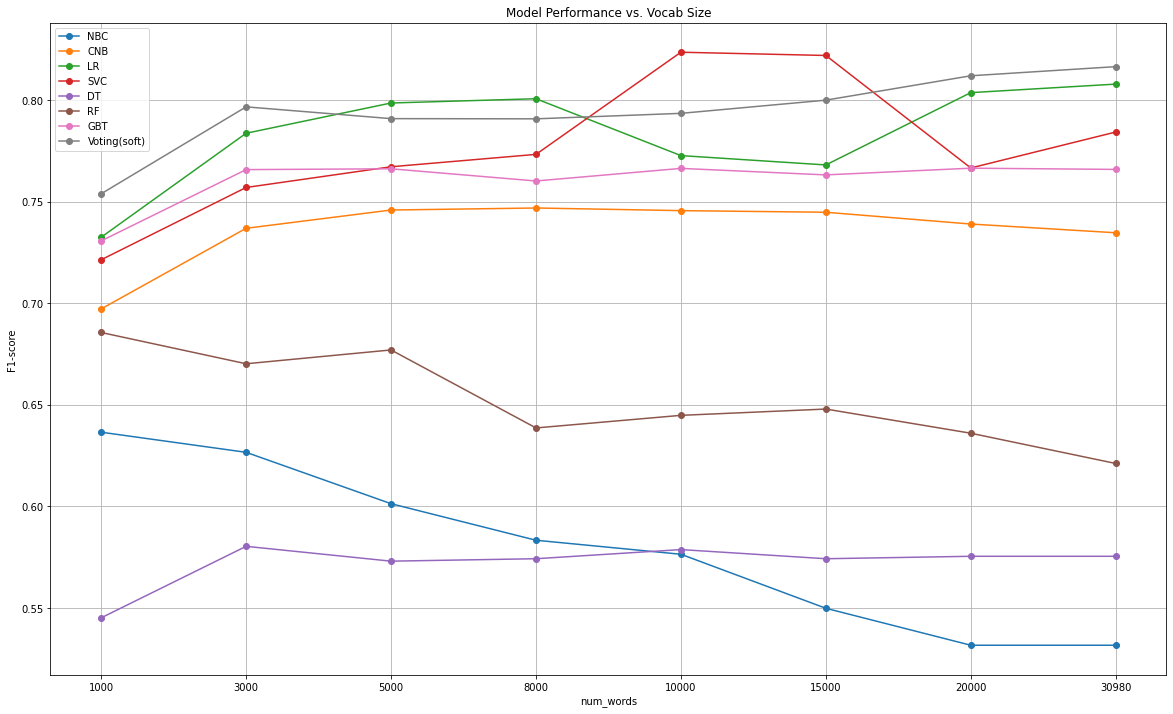

In [115]:
# 📌 DataFrame 생성
df_results = pd.DataFrame(data)

# 📌 그래프 그리기
plt.figure(figsize=(20, 12))

# 각 모델별 선 그래프 그리기
for index, row in df_results.iterrows():
    plt.plot(df_results.columns[1:], row[1:], marker='o', linestyle='-', label=row["Model"])

# 그래프 설정
plt.xlabel("num_words")
plt.ylabel("F1-score")
plt.title("Model Performance vs. Vocab Size")
plt.legend(loc="best")
plt.grid(True)
plt.show()

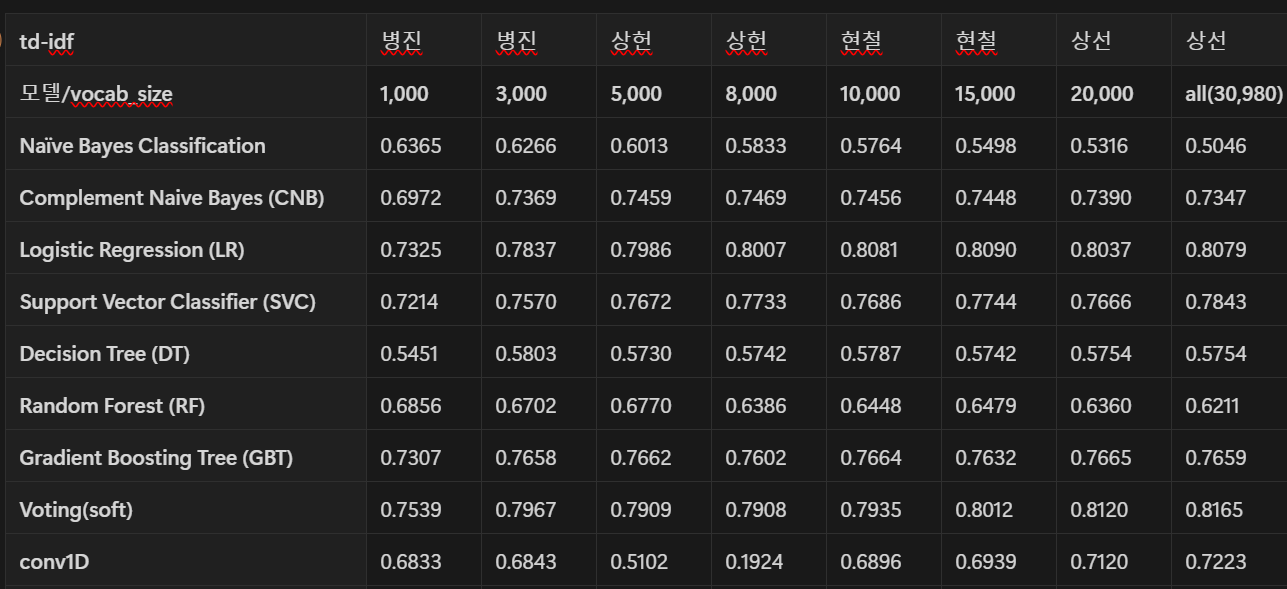

- 나이브베이즈(nbc) : 성능 떨어짐
- 컴플리먼트 나이브 베이즈(cnb) : 성능이 증가하다가 이후 떨어짐
- 로즈스틱 회귀(lr) : 성능이 증가함(중간에 추춤하긴함)
- 서포트 벡터(SVC) : 성능이 증가하다가 이후 떨어짐
- 의사결정나무(DT) : 1000일땐 성능이 낮으나 이후 성능이 거의 일정
- 랜덤포레스트(rf) : 성능 떨어짐
- 그래디언트 부스팅(gbt) : 1000일땐 성능이 낮으나 이후 성능이 거의 일정
- 보팅(voting-로지스틱 회귀, CNB, 그래디언트 부스팅 트리) : 성능 증가함

1. 나이브베이즈
- 단어 출현 확률 기반으로 클라쓰 분류하기때문에 단어가 많아지면 확률 계산이 어려워서 성능이 떨어지는거 같음

2. CNB
- 클래스가 한쪽으로 치우쳐져있을때(데이터불균형) 나이브베이즈 분류기 보완한것
- 클래스가 불균형한 데이터기 때문에 성능이 우수
- 단어가 많아질수록 성능이 떨어지는건 나이브베이즈 기반 확률이기때문에 단어가 많아지면 확률 계산이 어려워서 떨어지는거 같음

3. lr
- 

4. SVC
-

5. DT, GBT
- 그래디언트 부스팅 모델이 의사결정나무를 여러개 앙상블해서 평가하는 모데인 만큼 전체 성능은 GBT가 DT보다 우수하나 단어갯수별 패턴은 동일


6. RF
- 이것도 의사결정나무 랜덤으로 앙상블하는걸로 알고있는데 왜 성능이 떨어질까?

    -> DT 기반 모델(DT, GBT, RF)는 단어가 많아진다고 성능이 좋아지진않는다.

7. 보팅
- lr, cnb, gbt 3개모델, 즉 선형회귀, 확률기반, 의사결정나무기반로 모델 3개가 부족한 부분을 보완해줘서 성능이 오르는느낌? 


### 딥러닝 결과

In [128]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

max_len = np.max(list(map(lambda x: len(x), x_train)))
print(f"문장의 최대 길이 : {max_len}")


batch_size = 32
embedd_size = 100

# 훈련셋
pad_x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen = max_len)
num_words = np.max(pad_x_train) + 1
y_tmp = y_train.reshape(-1,1)
buffer = len(y_tmp)
tf_data = tensorflow_dataset(pad_x_train, y_tmp, buffer, batch_size)

# 테스트셋
total_num_test = len(x_test)
pad_x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen = max_len)
y_tmp_test = y_test.reshape(-1,1)
tf_test = tensorflow_dataset(pad_x_test, y_tmp_test, buffer, batch_size)

model = Conv1D(num_words, embedd_size)

model.compile(loss = "sparse_categorical_crossentropy",
                  optimizer = "adam",
                  metrics = ["accuracy"])

early_stopping = EarlyStopping(monitor="accuracy", patience=3, restore_best_weights=True)


model.fit(tf_data,
              steps_per_epoch = buffer // batch_size,
              epochs = 100,
              callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(tf_test, steps = total_num_test // batch_size)
print(f"test loss : {test_loss}")
print(f"test acc : {test_acc}")

y_pred = model.predict(pad_x_test) #테스트 데이터에 대한 예측
y_pred = np.argmax(y_pred, axis = 1)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"정확도:", acc)
print(f"F1-socre:", f1)

문장의 최대 길이 : 2376
Epoch 1/100
280/280 [==============================] - 3s 10ms/step - loss: 1.8988 - accuracy: 0.5294
Epoch 2/100
280/280 [==============================] - 3s 10ms/step - loss: 1.1555 - accuracy: 0.7184
Epoch 3/100
280/280 [==============================] - 3s 10ms/step - loss: 0.6863 - accuracy: 0.8337
Epoch 4/100
280/280 [==============================] - 3s 10ms/step - loss: 0.3999 - accuracy: 0.9100
Epoch 5/100
280/280 [==============================] - 3s 10ms/step - loss: 0.2657 - accuracy: 0.9398
Epoch 6/100
280/280 [==============================] - 3s 10ms/step - loss: 0.2039 - accuracy: 0.9516
Epoch 7/100
280/280 [==============================] - 3s 10ms/step - loss: 0.1921 - accuracy: 0.9517
Epoch 8/100
280/280 [==============================] - 3s 10ms/step - loss: 0.1767 - accuracy: 0.9527
Epoch 9/100
280/280 [==============================] - 3s 10ms/step - loss: 0.1622 - accuracy: 0.9531
Epoch 10/100
280/280 [==============================] - 3s 10ms/s

- 충분히 학습 돌려도 f1-score는 0,73
- Conv1D가 텍스트 데이터에 적합하지 않아서 머신러닝보다 성능이 낮을 가능성